Run this script to compute or plot potential energy surface color-coded for photonic/excitonic contribution for different cavity parameters.

In [18]:
### Import all libraries and define various parameters here!
import numpy as np
from polaritonic import polaritonic
from numpy import linalg as LA
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

The following cell will actually compute the derivative coupling and write it to a file.  
You can change the $\gamma$ parameter (via the `gamp=X` line) and the filename (via `prefix = Y` line) here!

In [19]:
ri_init = -0.66156
vi_init = 3.3375e-5
'''NOTE 1:  when you change gamp, you change the lifetime in Hamiltonian!'''
### lifetime
gamp = 0.0
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
gp = 0.05 * np.sqrt(5)
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
'''NOTE 2:  when you prefix, it will change the file name that the data is written to, and in the next cell that 
   plots the data, this file name will automatically be read from.  Make sure you change the prefix accordingly each 
   time you change the gamp parameter.'''
prefix = "gam_10.0"
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'

### hellman-Feynman file 
hf_fn = "Data/" + prefix + "_hf.txt"
dc_fn = "Data/" + prefix + "_dc.txt"
ip_fn = "Data/" + prefix + "_ip.txt"
### perturbative approimation to dc data
ptdc_fn = "Data/" + prefix + "_ptdc.txt"
filename = prefix + ".eps"

options = {
        'Number_of_Photons': 1,
        'Complex_Frequency': True,
        'Photon_Energys': [omc],
        'Coupling_Strengths': [gc], 
        'Photon_Lifetimes': [gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)
### write forces and derivative coupling
#polt.Transform_L_to_P()



Initialize R, find local slope and curvature of each surface, then compute the global surfaces with 
correct ordering and write them to data files.

In [20]:
### initialize near the lhs of the PESs
polt.R = -1.25
### get local slope curvature of each surface at R = -1.25
polt.init_slope_and_curve()
### write the potential energy surfaces, the derivative couplings, and the polaritonic inner-product and left/right
### eigenvector data to files
polt.Write_PES(pes_fn, pc_fn, dc_fn, ptdc_fn, ip_fn)

1

The "PES" file contains the following (complex) data as columns (in order):

$R, \; \epsilon_{g0}, \: \epsilon_{LP}, \; \epsilon_{UP}, \; \epsilon_{e1}$

The "derivative coupling" file contains the following (complex) data as columns (in order):

$R, \; \langle LP | \frac{d}{dR} UP \rangle, \; \langle UP | \frac{d}{dR} LP \rangle$

The "inner-product" file contains the following data as columns (in order):

$R, \; \langle rLP | rLP \rangle,\; \langle rUP | rUP \rangle, \; \langle rLP | rUP \rangle, 
\; \langle rUP | rLP \rangle,  \; || \: |lLP^* \rangle-|rLP \rangle \: ||, \;  || \: |lUP^* \rangle-|rUP \rangle \: ||$

where $| rLP \rangle$ denotes the right LP eigenstate and $| lLP \rangle$ denotes the left LP eigenstate.

### Check the inner-product quantities first!

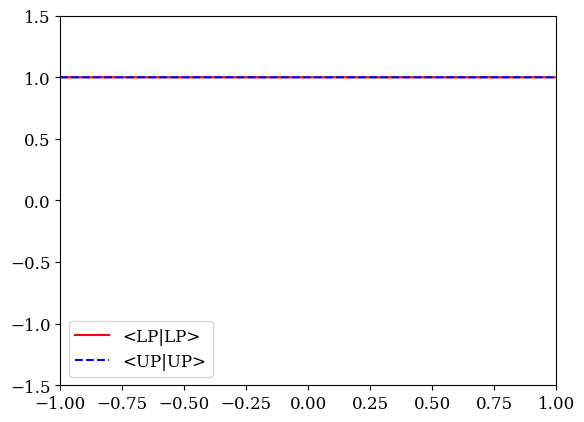

In [21]:
ip = np.loadtxt(ip_fn,dtype=complex)
plt.plot(ip[:,0], np.abs(ip[:,1]), 'red', label="<LP|LP>")
plt.plot(ip[:,0], np.abs(ip[:,2]), 'b--', label="<UP|UP>")
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1.5,1.5)
plt.show()

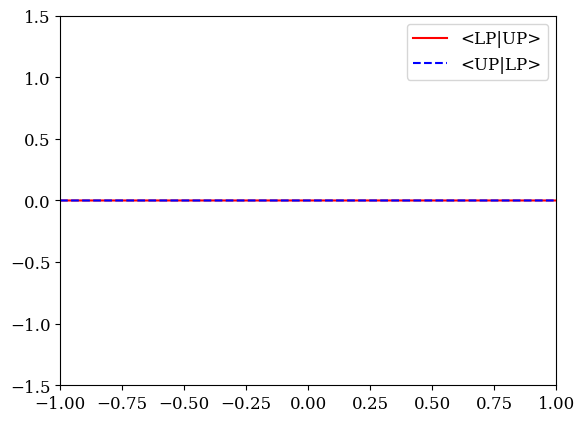

In [22]:
plt.plot(ip[:,0], np.imag(ip[:,3]),'red', label="<LP|UP>")
plt.plot(ip[:,0], np.imag(ip[:,4]),'b--', label="<UP|LP>")
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1.5,1.5)
plt.show()

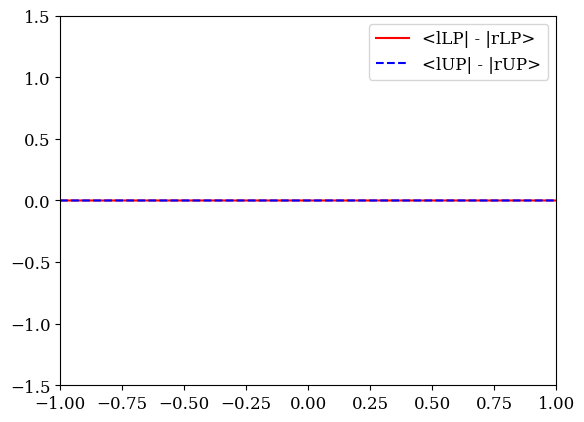

In [23]:
plt.plot(ip[:,0], np.abs(ip[:,5]), 'red', label="<lLP| - |rLP>")
plt.plot(ip[:,0], np.abs(ip[:,6]), 'b--', label="<lUP| - |rUP>")
plt.legend()
plt.xlim(-1,1)
plt.ylim(-1.5,1.5)
plt.show()

### Check the derivative coupling quantities next!

In [24]:
dc_0p1 = np.loadtxt("Data/gam_0.1_dc.txt",dtype=complex)
dc_1 = np.loadtxt("Data/gam_1.0_dc.txt",dtype=complex)
dc_10 = np.loadtxt("Data/gam_10.0_dc.txt",dtype=complex)
dc_100 = np.loadtxt("Data/gam_100.0_dc.txt",dtype=complex)

plt.plot(dc_10[:,0], np.real(dc_10[:,2]), 'g*')
plt.plot(dc_1[:,0], np.real(dc_1[:,2]), 'b*')
plt.plot(dc_0p1[:,0], np.real(dc_0p1[:,2]), 'r*')

#plt.plot(dc_100[:,0], np.imag(dc_100[:,2]), 'purple')

#plt.plot(eval_spline, re_dc_32_spline(eval_spline), 'b--')
#plt.xlim(-0.65,-0.55)

FileNotFoundError: Data/gam_0.1_dc.txt not found.

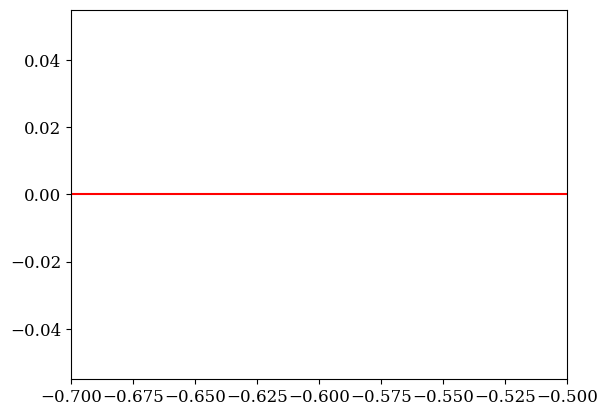

-2.7093530680419957e-05


In [25]:
### finite difference
dc = np.loadtxt(dc_fn,dtype=complex)
### perturbative
ptdc = np.loadtxt(ptdc_fn,dtype=complex)


spline_axis = np.real(dc[:,0])
eval_spline = np.linspace(-1.5, 1.5, 50000)

re_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,1]), k=3)
im_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,1]), k=3)

re_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.real(dc[:,2]), k=3)
im_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(dc[:,2]), k=3)


pt_re_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.real(ptdc[:,1]), k=3)
pt_im_dc_23_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(ptdc[:,1]), k=3)

pt_re_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.real(ptdc[:,2]), k=3)
pt_im_dc_32_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(ptdc[:,2]), k=3)

plt.plot(spline_axis, im_dc_23_spline(spline_axis), 'red')
#plt.plot(eval_spline, re_dc_32_spline(eval_spline), 'b--')
plt.xlim(-0.7,-0.5)
plt.show()
polt.Initialize_Phase_Space()
print(polt.V)



Once the derivative coupling has been written to a file (or several have been written to a file), you can parse the files and plot them with the following cell!

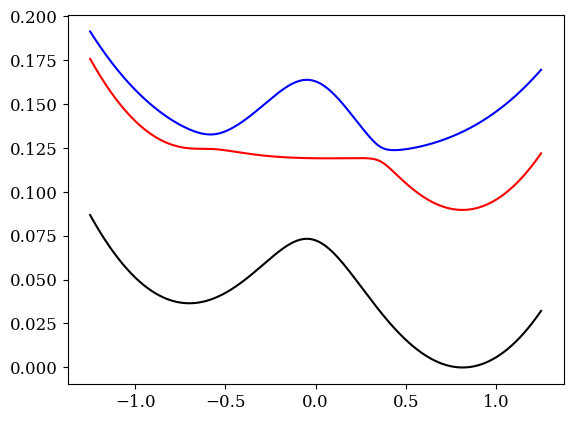

In [26]:
pes_v = np.loadtxt(pes_fn, dtype=complex)
spline_axis = np.real(pes_v[:,0])
pc_v = np.loadtxt(pc_fn,dtype=complex)
 
# g0
re_g0_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,1]), k=3)
im_g0_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,1]), k=3)

# LP
re_LP_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,2]), k=3)
im_LP_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,2]), k=3)

# UP
re_UP_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,3]), k=3)
im_UP_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,3]), k=3)

# e1
re_e1_spline = InterpolatedUnivariateSpline(spline_axis, np.real(pes_v[:,4]), k=3)
im_e1_spline = InterpolatedUnivariateSpline(spline_axis, np.imag(pes_v[:,4]), k=3)

color1 = "black"
color2 = "royalblue"
color3 = "darkorchid"
color4 = "tomato"



#plt.plot(spline_axis, re_LP_spline(spline_axis), 'red')
#plt.plot(spline_axis, re_UP_spline(spline_axis), 'blue')
#plt.plot(spline_axis, re_e1_spline(spline_axis), 'purple')
plt.show()

plt.plot(spline_axis, re_g0_spline(spline_axis), 'black')
plt.plot(spline_axis, re_LP_spline(spline_axis), 'red')
plt.plot(spline_axis, re_UP_spline(spline_axis), 'blue')
#plt.plot(spline_axis, re_e1_spline(spline_axis), 'purple')
plt.show()

#plt.plot(pes_v[:,0], 27.211*np.real(pes_v[:,2]), 'blue')
#plt.plot(pes_v[:,0], np.imag(pes_v[:,2]), 'b*')
#plt.plot(pes_v[:,0], np.imag(pes_v[:,3]), 'r*')
#plt.plot(pes_v[:,0], 27.211*np.real(pes_v[:,3]), 'red')
#plt.xlim(-0.7,-0.5)
#plt.ylim(3.2, 4.02)
#plt.show()



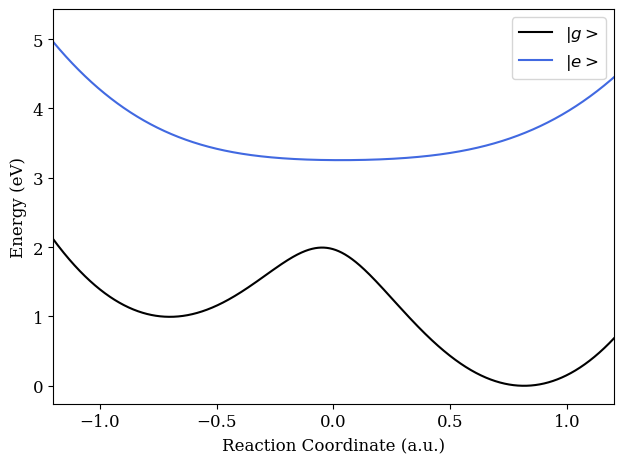

In [27]:
# plot the |g,0>, |g,1> and |e,0> curves
plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis), color=color1, label="$|g>$")
#plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis) + omp, color=color4, label="$|g,1>$")
plt.plot(spline_axis, 27.2114 * re_e1_spline(spline_axis) - omp, color=color2, label="$|e>$")
plt.tight_layout()
plt.xlabel("Reaction Coordinate (a.u.)")
plt.ylabel("Energy (eV)")
plt.xlim(-1.2,1.2)
plt.tight_layout()
plt.legend()
plt.savefig("bare_surfaces.png", dpi=250)
plt.show()



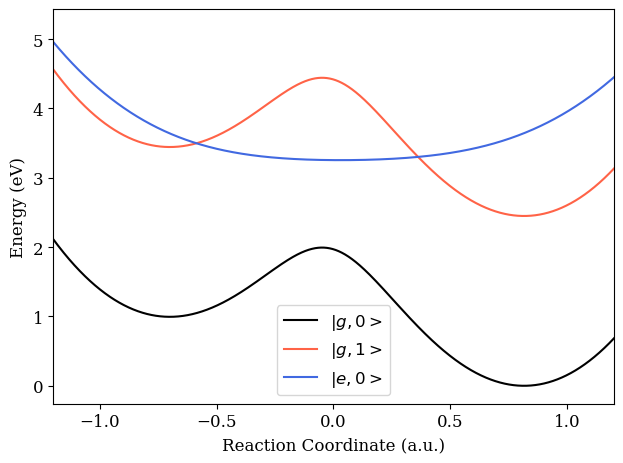

In [28]:
# plot the |g,0>, |g,1> and |e,0> curves
plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis), color=color1, label="$|g,0>$")
plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis) + omp, color=color4, label="$|g,1>$")
plt.plot(spline_axis, 27.2114 * re_e1_spline(spline_axis) - omp, color=color2, label="$|e,0>$")
plt.tight_layout()
plt.xlabel("Reaction Coordinate (a.u.)")
plt.ylabel("Energy (eV)")
plt.xlim(-1.2,1.2)
plt.tight_layout()
plt.legend()
plt.savefig("dressed_surfaces.png", dpi=250)
plt.show()



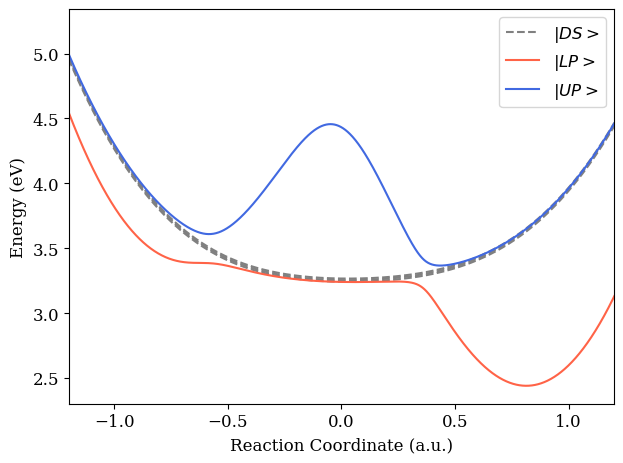

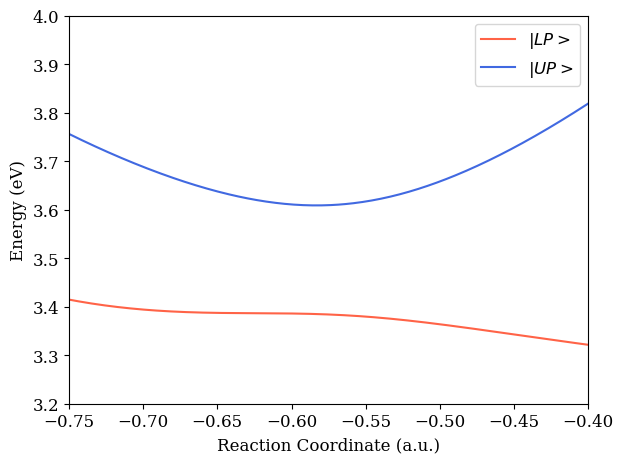

In [38]:
#plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis), color=color1, label="$|g,0>$")
plt.plot(spline_axis, 27.2114 * re_e1_spline(spline_axis) - omp, color="gray", linestyle="dashed", label="$|DS>$")
plt.plot(spline_axis, 27.2114 * re_e1_spline(spline_axis) - omp * 0.995, color="gray", linestyle="dashed")
plt.plot(spline_axis, 27.2114 * re_e1_spline(spline_axis) - omp * 1.005, color="gray", linestyle="dashed")
plt.plot(spline_axis, 27.2114 * re_LP_spline(spline_axis), color=color4, label="$|LP>$")
plt.plot(spline_axis, 27.2114 * re_UP_spline(spline_axis), color=color2, label="$|UP>$")


plt.tight_layout()
plt.xlabel("Reaction Coordinate (a.u.)")
plt.ylabel("Energy (eV)")
plt.xlim(-1.2,1.2)
plt.tight_layout()
plt.legend()
plt.savefig("tccoupled_surfaces.png", dpi=250)
plt.show()


#plt.plot(spline_axis, 27.2114 * re_g0_spline(spline_axis), color=color1, label="$|g,0>$")
plt.plot(spline_axis, 27.2114 * re_LP_spline(spline_axis), color=color4, label="$|LP>$")
plt.plot(spline_axis, 27.2114 * re_UP_spline(spline_axis), color=color2, label="$|UP>$")
plt.xlabel("Reaction Coordinate (a.u.)")
plt.ylabel("Energy (eV)")
plt.xlim(-.75,-0.4)
plt.ylim(3.2, 4)
plt.tight_layout()
plt.legend()
plt.savefig("zoomed_coupled_surfaces.png", dpi=250)
plt.show()

dc matrix
[[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   4.35847999e-04-0.j]
 [ 0.00000000e+00-0.j  0.00000000e+00+0.j -1.78964146e+01+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00-0.j  1.77978237e+01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-4.35847999e-04-0.j  0.00000000e+00-0.j  0.00000000e+00-0.j
   0.00000000e+00+0.j]]
ham matrix
[[0.03033141+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.11894377+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.12272634+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.2113387 +0.j]]
initial wavefunction
[ 0.        +0.j         -0.0097138 -0.00814162j  0.33756781-0.94121634j
  0.        +0.j        ]


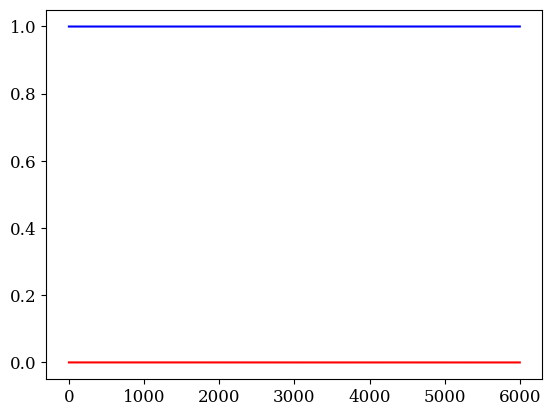

[ 0.        +0.j          0.00153216+0.00863301j -0.77196409-0.63560599j
  0.        +0.j        ]


In [56]:
ci=0+1j
polt.R = 0.37
n_time = 50000
t_array = np.zeros(n_time)
pop = np.zeros((2,n_time))

polt.H_polariton = np.zeros((4,4),dtype=complex)
polt.dc[1,2] = re_dc_23_spline(polt.R) + im_dc_23_spline(polt.R)*ci
polt.dc[2,1] = re_dc_32_spline(polt.R) + im_dc_32_spline(polt.R)*ci

print("dc matrix")
print(polt.dc)

polt.H_polariton[0,0] = re_g0_spline(polt.R)+ci*im_g0_spline(polt.R)
polt.H_polariton[1,1] = re_LP_spline(polt.R)+ci*im_LP_spline(polt.R)
polt.H_polariton[2,2] = re_UP_spline(polt.R)+ci*im_UP_spline(polt.R)
polt.H_polariton[3,3] = re_e1_spline(polt.R)+ci*im_e1_spline(polt.R)

print("ham matrix")
print(polt.H_polariton)

print("initial wavefunction")
print(polt.C_polariton)

for i in range(0,n_time):
    t_array[i] = i*polt.dt
    polt.RK4_NH_SE()
    #print("new pop LP ",i)
    pop[0,i] = np.real(np.conj(polt.C_polariton[1])*polt.C_polariton[1])
    #print("new pop UP ",i)
    pop[1,i] = np.real(np.conj(polt.C_polariton[2])*polt.C_polariton[2])
    
    
plt.plot(t_array, pop[0,:], 'red')
plt.plot(t_array, pop[1,:], 'blue')
plt.show()
#polt.RK4_NH_SE()

#print("new wavefunction 2")
#print(polt.C_polariton)
#print("new pop LP 2")
#print(np.conj(polt.C_polariton[1])*polt.C_polariton[1])
#print("new pop UP 2")
#print(np.conj(polt.C_polariton[2])*polt.C_polariton[2])
#polt.C_polariton = np.copy(polt.C_polariton + dcdt * polt.dt)

#dcdt = np.copy(-1*polt.V * np.dot(polt.dc, polt.C_polariton))
#polt.C_polariton = np.copy(polt.C_polariton + dcdt * polt.dt)


print(polt.C_polariton)


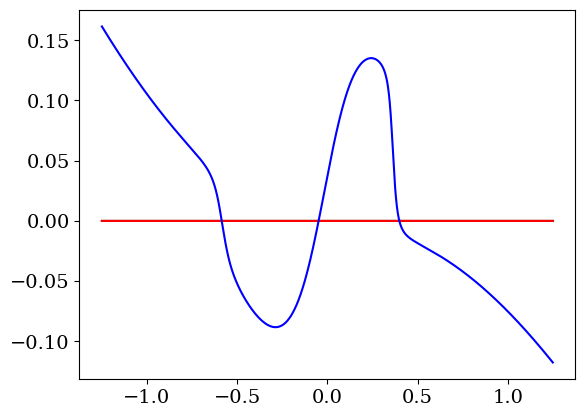

In [19]:
# g0
re_g0_force = re_g0_spline.derivative()
im_g0_force = im_g0_spline.derivative()

# LP
re_LP_force = re_LP_spline.derivative()
im_LP_force = im_LP_spline.derivative()

# UP
re_UP_force = re_UP_spline.derivative()
im_UP_force = re_UP_spline.derivative()




plt.plot(spline_axis, -1*im_g0_force(spline_axis), 'black')
plt.plot(spline_axis, -1*im_LP_force(spline_axis), 'red')
plt.plot(spline_axis, -1*im_UP_force(spline_axis), 'blue')
#plt.plot(spline_axis, re_e1_spline(spline_axis), 'purple')
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_48415/1095288227.py:8: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(dc[:,0], np.imag(dc[:,3]), 'red', label='$\gamma$=100 meV')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


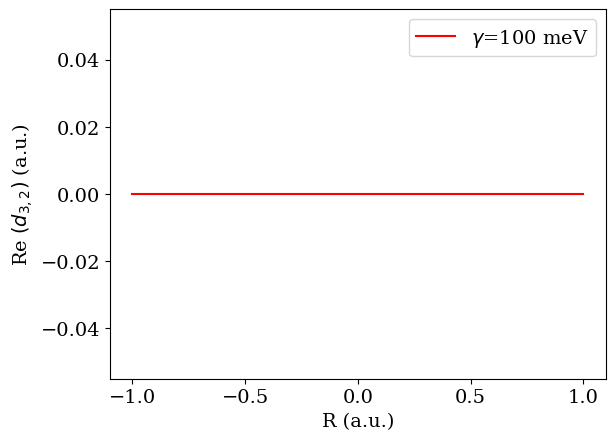

In [20]:
polt.Write_Forces(hf_fn)

LP_force = re_LP_spline.derivative()
### read text file
dc = np.loadtxt(hf_fn,dtype=complex)

### plot the data!
plt.plot(dc[:,0], np.imag(dc[:,3]), 'red', label='$\gamma$=100 meV')
#plt.plot(dc[:,0], -1*LP_force(np.real(dc[:,0])), 'blue', label='$\gamma$=100 meV')
#plt.plot(dc[:,0], np.real(dc[:,1]), 'red', label='$\gamma$=100 meV')

#plt.plot(dc_1p0[:,0], np.imag(dc_1p0[:,3]), 'b--', label='$\gamma$=1.0 meV')
#plt.plot(dc_10p0[:,0], np.imag(dc_10p0[:,3]), 'g--', label='$\gamma$=10.0 meV')
plt.legend()
#plt.xlim(-0.75,0.5)
plt.xlabel("R (a.u.)")
plt.ylabel("Re $( d_{3,2} )$ (a.u.)")
plt.savefig("DC_abs.eps")
plt.show()

/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_48415/383555665.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('rainbow')
/opt/homebrew/Caskroom/miniforge/base/envs/p4env/lib/python3.12/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/homebrew/Caskroom/miniforge/base/envs/p4env/lib/python3.12/site-packages/matplotlib/axes/_axes.py:4455: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


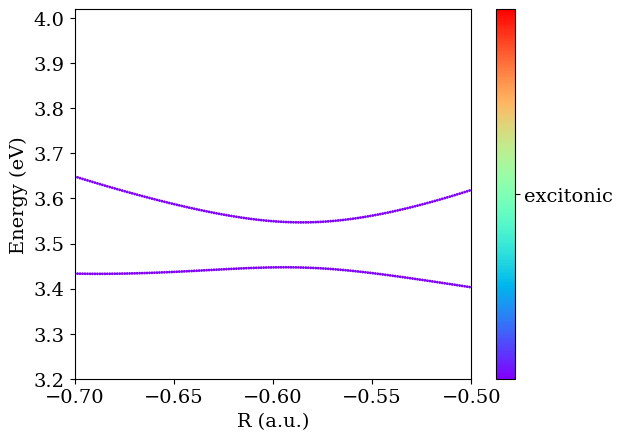

In [21]:
### read text file

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,1]), c='black',s=1) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,2]), c=np.abs(np.imag(pes_v[:,2])),cmap=cm, s=1) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,3]), c=np.abs(np.imag(pes_v[:,3])),cmap=cm, s=1)
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=1)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1 ])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
#plt.xlim(-0.625,-0.55)
#plt.ylim(3.2, 4.02)
plt.xlim(-0.7,-0.5)
plt.ylim(3.2, 4.02)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
#plt.savefig(filename)
plt.show()



In [22]:
### just playing around here
polt.R = -0.5
polt.H_e()
polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
polt.Transform_L_to_P('True')
print(polt.H_polariton[0,0])
print(polt.H_polariton[1,1])
print(polt.H_polariton[2,2])
print(polt.H_polariton[3,3])

TypeError: can't multiply sequence by non-int of type 'numpy.complex128'

In [ ]:
### read text file
#pes_v = np.loadtxt(pes_fn, dtype=complex)
#spline_axis = np.real(pes_v[:,0])
#pc_v = np.loadtxt(pc_fn,dtype=complex)

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,1]), c='black', s=4) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,2]), c=pc_v[:,2],cmap=cm, s=6) 
im = ax.scatter(pes_v[:,0], 27.211*np.real(pes_v[:,3]), c=pc_v[:,3],cmap=cm, s=6)
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-0.70,-0.5)
plt.ylim(3.25,3.75)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
plt.savefig("PES_gamma_10.0mev_zoom.eps")
plt.show()



In [ ]:
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_0p1[:,2])), 'g--' )
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_0p1[:,3])), 'green',label="$\hbar \gamma$ = 0.1 meV" )
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_10[:,2])), 'b--' )
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_10[:,3])), 'blue',label="$\hbar \gamma$ = 10 meV" )
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_100[:,2])), 'r--' )
plt.plot(pes_v[:,0], np.log10(-27.211*np.imag(pes_v_100[:,3])), 'red',label="$\hbar \gamma$ = 100 meV" )
plt.xlabel("R (a.u.)")
plt.ylabel("Log(-Im(E))")
plt.legend()
plt.ylim(-8,4)
#plt.xlim(-0.64,-0.54)
plt.savefig("IM_PES_gamma_0.1mev_zoom.eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()
#cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,1]), c='black', s=4, label='|g>') 
im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c='red',s=4, label='|e>') 
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,3]), c=pc_v[:,3],cmap=cm, s=4)
#im = ax.scatter(pes_v[:,0], 27.211*np.abs(pes_v[:,4]), c=pc_v[:,4],cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.0,1.0)
plt.ylim(-0.1,5.0)
#plt.legend()
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
plt.savefig(filename)
plt.show()